### Loading Libraries

In [6]:
library(vegan)
library(phyloseq)
library(ranacapa)
library(ape)
library(ggplot2)
library(ggpubr)
library(reshape2)

In [7]:
# create directories to save files
dir.create(file.path('../../results/figures'), showWarnings = FALSE)
dir.create(file.path('../../results/figures', 'figure2'), showWarnings = FALSE)

# Alpha Diversity & Rarefraction

### Loading Data

In [8]:
# load phyloseq object
ps <- readRDS('../../data/phyloseq/nohost_asv/phyloseq.rds')
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 17022 taxa and 199 samples ]
sample_data() Sample Data:       [ 199 samples by 57 sample variables ]
tax_table()   Taxonomy Table:    [ 17022 taxa by 7 taxonomic ranks ]

In [12]:
# create a 'time_and_STHStatus' metadata column
# this column has 4 values:
#    baseline_noSTH: a sample is from a baseline cohort, no STH eggs detected at the baseline
#    baseline_STH: a sample is from a baseline cohort, STH eggs detected at the baseline
#    followup_noSTH_noSTH: a sample is from a follow-up cohort, STH-negative at both: the baseline and the follow-up
#    followup_noSTH_STH: a sample is from a follow-up cohort, STH-negative at the baseline, STH-positive at the follow-up
#    followup_STH_noSTH: a sample is from a follow-up cohort, STH-positive at the baseline, STH-negative at the follow-up
#    followup_STH_STH: a sample is from a follow-up cohort, STH-positive at both: the baseline and the follow-up
# p.s. a sample is considered STH-negative at the given collection timepoint, 
# if no STH eggs were detected at the given timpoint
# p.p.s. a sample is considered STH-positive at the given collection timepoint, 
# if at least on STH egg  detected at the given timpoint

# create a new variable (the length = number of of samples) and name everyone as baseline_noSTH
STHStatus <- rep('baseline_noSTH', dim(sample_data(ps))[1])
# mark indexes (TRUE/FALSE) of baseline samples with detected STH at the baseline
STHStatus_baseline_all <- ((sample_data(ps)[['collection_timepoint']] == 'baseline') & 
                       (sample_data(ps)[['sample_eggcountAnySTHs']] > 0))
# rename
STHStatus[STHStatus_baseline_all] <- 'baseline_STH'

# find IDs of participants who were STH-free at the baseline
subjectID <- sample_data(ps)[STHStatus == 'baseline_noSTH', ]$host_subject_id
noSTH <- (sample_data(ps)$host_subject_id %in% subjectID)&(sample_data(ps)$collection_timepoint == 'follow-up')

# mark indexes as TRUE if 
# 1) a sample is from a follow-up cohort and 
# 2) a sample belongs to the participant who  STH-free at the baseline
STHStatus_followup <- (sample_data(ps)[['collection_timepoint']] == 'follow-up') & noSTH
# name all of them followup_noSTH_noSTH
STHStatus[STHStatus_followup] <- 'followup_noSTH_noSTH'
# mark indexes as TRUE if 
# 1) a sample is from a follow-up cohort and 
# 2) a sample belongs to the participant who  STH-free at the baseline and
# 3) there are STH eggs detected at the follow-up time point
STHStatus_followup <- ((sample_data(ps)[['collection_timepoint']] == 'follow-up') & 
                   (sample_data(ps)[['sample_eggcountAnySTHs']] > 0) & noSTH)
# rename all of them followup_noSTH_STH
STHStatus[STHStatus_followup] <- 'followup_noSTH_STH'

# find IDs of participants who were STH-positive at the baseline
subjectID <- sample_data(ps)[STHStatus == 'baseline_STH', ]$host_subject_id
STH <- (sample_data(ps)$host_subject_id %in% subjectID)&(sample_data(ps)$collection_timepoint == 'follow-up')
# mark indexes as TRUE if 
# 1) a sample is from a follow-up cohort and 
# 2) a sample belongs to the participant who  STH-positive at the baseline
STHStatus_followup <- (sample_data(ps)[['collection_timepoint']] == 'follow-up') & STH
# rename such samples
STHStatus[STHStatus_followup] <- 'followup_STH_noSTH'
# mark indexes as TRUE if 
# 1) a sample is from a follow-up cohort and 
# 2) a sample belongs to the participant who  STH-positive at the baseline and
# 3) there are STH eggs detected at the follow-up time point
STHStatus_followup <- ((sample_data(ps)[['collection_timepoint']] == 'follow-up') & 
                   (sample_data(ps)[['sample_eggcountAnySTHs']] > 0) & STH)
# rename such samples
STHStatus[STHStatus_followup] <- 'followup_STH_STH'

# create a new column in phyloseq metadata table
sample_data(ps)['time_and_STHStatus'] <- STHStatus

In [13]:
# rename groups to combine follow-up sample with different STH status based on their baseline STH status
STHStatus <- factor(STHStatus) # factorize
levels(STHStatus) <- c('baseline_noSTH', 'baseline_STH', 
                       'followup_noSTH', 'followup_noSTH', 
                       'followup_STH', 'followup_STH') # regroup
sample_data(ps)['time_and_STHStatus'] <- as.character(STHStatus) # create a new metadata variable

### Alpha-diversity
Steps: 
1. Rarefy to the depth 
2. Compute alpha-diversity & assess significance using Wilcoxon signed rank test

In [14]:
# set the metadata column we will use for the analysis
comparison_group = 'time_and_STHStatus'

#### 1. Rarefy

In [15]:
set.seed(295) # setting seed to replicate the randomized rarefraction
# rarefy phyloseq object
ps_rarefied <- rarefy_even_depth(ps, 1e+05)
ps_rarefied

You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`


...

3 samples removedbecause they contained fewer reads than `sample.size`.

Up to first five removed samples are: 


sample_044sample_063sample_168

...

2379OTUs were removed because they are no longer 
present in any sample after random subsampling


...



phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14643 taxa and 196 samples ]
sample_data() Sample Data:       [ 196 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 14643 taxa by 7 taxonomic ranks ]

rarefying sample sample_001
rarefying sample sample_002
rarefying sample sample_003
rarefying sample sample_004
rarefying sample sample_005
rarefying sample sample_006
rarefying sample sample_007
rarefying sample sample_008
rarefying sample sample_009
rarefying sample sample_010
rarefying sample sample_011
rarefying sample sample_012
rarefying sample sample_013
rarefying sample sample_014
rarefying sample sample_015
rarefying sample sample_016
rarefying sample sample_017
rarefying sample sample_018
rarefying sample sample_019
rarefying sample sample_020
rarefying sample sample_021
rarefying sample sample_022
rarefying sample sample_023
rarefying sample sample_024
rarefying sample sample_025
rarefying sample sample_026
rarefying sample sample_027
rarefying sample sample_028
rarefying sample sample_029
rarefying sample sample_030
rarefying sample sample_031
rarefying sample sample_032
rarefying sample sample_033
rarefying sample sample_034
rarefying sample sample_035
rarefying sample sam

Warning message in vegan::rarefy(x[i, , drop = FALSE], n, se = se):
“most observed count data have counts 1, but smallest count is 6”


rarefying sample sample_134
rarefying sample sample_135
rarefying sample sample_136
rarefying sample sample_137
rarefying sample sample_138


Warning message in vegan::rarefy(x[i, , drop = FALSE], n, se = se):
“most observed count data have counts 1, but smallest count is 2”


rarefying sample sample_139
rarefying sample sample_140
rarefying sample sample_141
rarefying sample sample_142
rarefying sample sample_143
rarefying sample sample_144
rarefying sample sample_145
rarefying sample sample_146
rarefying sample sample_147
rarefying sample sample_148
rarefying sample sample_149
rarefying sample sample_150
rarefying sample sample_151
rarefying sample sample_152
rarefying sample sample_153


Warning message in vegan::rarefy(x[i, , drop = FALSE], n, se = se):
“most observed count data have counts 1, but smallest count is 2”


rarefying sample sample_154
rarefying sample sample_155
rarefying sample sample_156
rarefying sample sample_157
rarefying sample sample_158
rarefying sample sample_159
rarefying sample sample_160
rarefying sample sample_161
rarefying sample sample_162
rarefying sample sample_163
rarefying sample sample_164
rarefying sample sample_165
rarefying sample sample_166
rarefying sample sample_167
rarefying sample sample_169
rarefying sample sample_170
rarefying sample sample_171
rarefying sample sample_172
rarefying sample sample_173
rarefying sample sample_174
rarefying sample sample_175
rarefying sample sample_176
rarefying sample sample_177
rarefying sample sample_178
rarefying sample sample_179
rarefying sample sample_180
rarefying sample sample_181
rarefying sample sample_182
rarefying sample sample_183
rarefying sample sample_184
rarefying sample sample_185
rarefying sample sample_186
rarefying sample sample_187
rarefying sample sample_188
rarefying sample sample_189
rarefying sample sam

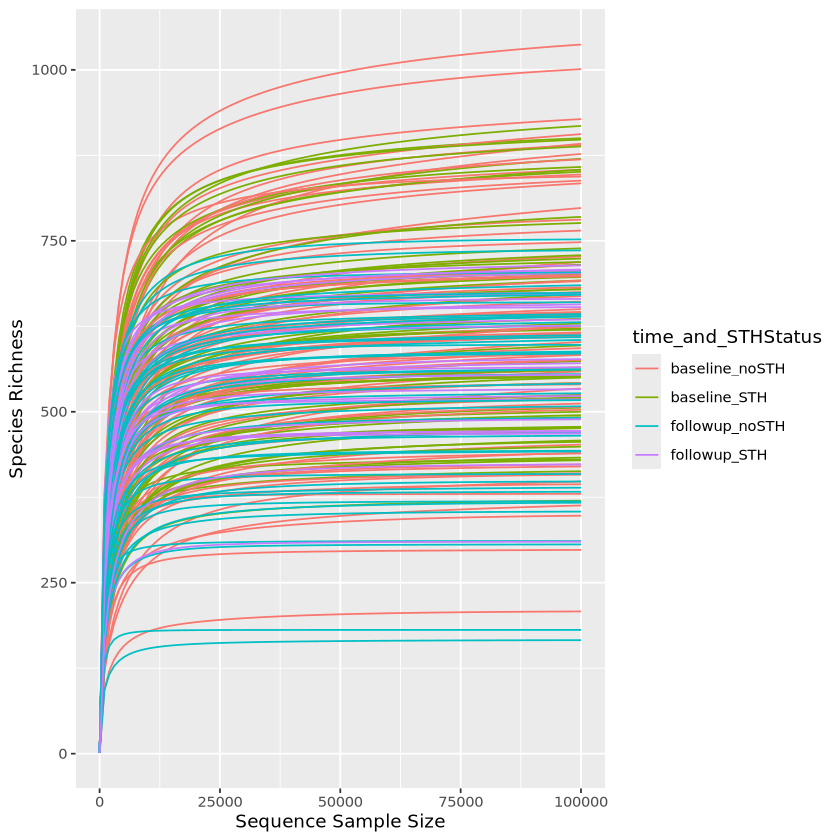

In [16]:
# look at the rarefraction curve
p <- ggrare(ps_rarefied, step = 1000, color = comparison_group, se = FALSE)

### Before Dependent

In [25]:
# set plot parameters
comparisons <- unique(sample_data(ps)[[comparison_group]])
symnum.args = list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05, 1), symbols = c("****", "***", "**", "*", "ns"))

In [26]:
# find ids of people who were dewormed
onlydewormed_ids <- sample_data(ps_rarefied)[sample_data(ps_rarefied)[['collection_timepoint']] == 'follow-up',]$host_subject_id
# select only samples from subjects participated in the follow-up study
ps_rarefied_onlywithdewormed <- subset_samples(ps_rarefied, host_subject_id %in% onlydewormed_ids)
# check if the size of the table matches to our expectation
length(onlydewormed_ids)*2 == nsamples(ps_rarefied_onlywithdewormed)

[1] TRUE

In [27]:
# compute alpha-diversity metrics
# Tutorial: https://rpubs.com/lconteville/713954
alpha_div <- data.frame(microbiome::alpha(ps_rarefied_onlywithdewormed, 
                                          index=c('observed', 'shannon', 'inverse_simpson')))
colnames(alpha_div) <- c('Observed', 'Shannon', 'Simpson')
alpha_div['ID'] <- row.names(alpha_div)
# add metadata information necessary for the comparison
alpha_div[comparison_group] <- sample_data(ps_rarefied_onlywithdewormed)[alpha_div$ID, comparison_group]
alpha_div[comparison_group] <- factor(alpha_div[[comparison_group]], 
                                     levels = c('baseline_noSTH',  'followup_noSTH', 
                                                'baseline_STH', 'followup_STH'))
alpha_div['host_subject_id'] <- sample_data(ps_rarefied_onlywithdewormed)[alpha_div$ID, 'host_subject_id']
alpha_div['collection_timepoint'] <- sample_data(ps_rarefied_onlywithdewormed)[row.names(alpha_div), 
                                                                            'collection_timepoint']

Observed richness

Other forms of richness

Diversity

Evenness

Dominance

Rarity



In [28]:
# to streamline the statistical comparisons, 
# create a new metadata column that will contain informtion about STH-status 
# at both collection timepoints for each participant
# the format is '[STHStatus at baseline]'
# noSTH means STH-negative, STH means STH-positive

# add the information about STH status at both stages to the alpha diversity table
alpha_div$STHStatus <- unlist(as.vector(lapply(alpha_div$time_and_STHStatus, function(x) strsplit(as.character(x), '_')[[1]][2])))
# factorize deworming column to maintain proper order
alpha_div$collection_timepoint <- factor(alpha_div$collection_timepoint, levels=c('follow-up', 'baseline'))

In [29]:
# compute significance for alpha-diversity metrics by making 4 comparisons:
# 1) compare before/after metrics within the group, who were STH-free at the baseline timepoint
# 2) compare before/after metrics within the group, who had STH-infection at the baseline timepoint

test_res <- data.frame()
for (metric in c('Observed', 'Shannon', 'Simpson')) {
    # transform the table for the convenience of the comparison
    div_table <- dcast(data = alpha_div, formula = host_subject_id + collection_timepoint ~ STHStatus,
                  fun.aggregate = sum, 
                  value.var = metric)
    # replace zero values with NaNs to not to skew the statistics with artificial zeros
    div_table['time_and_STHStatus'] <- as.factor(div_table[['time_and_STHStatus']]) 
    div_table[div_table$noSTH_noSTH == 0, 'noSTH'] <- NA
    div_table[div_table$noSTH_STH == 0, 'STH'] <- NA
    
    # 1) compare before/after metrics within the group, who were STH-free at the both timepoints
    stat.test <- compare_means(
      noSTH ~ collection_timepoint, data = div_table,
      method = "wilcox.test", paired=TRUE,
      id = 'host_subject_id',
    )
    stat.test['metric'] = metric
    test_res <- rbind(test_res, stat.test)
    
    # 2) compare before/after metrics within the group, who who acquired STH infection at the follow-up
    stat.test <- compare_means(
      STH ~ collection_timepoint, data = div_table,
      method = "wilcox.test", paired=TRUE,
      id = 'host_subject_id',
    )
    stat.test['metric'] = metric
    test_res <- rbind(test_res, stat.test)
}
# rename some for the consitency between alpha-diversity table metadata and p-values
test_res$group1 <- gsub('follow-up', 'followup_', paste0(test_res$group1, test_res[['.y.']]))
test_res$group2 <- paste0(test_res$group2, '_', lapply(strsplit(test_res[['.y.']], '_'), '[', 1))
# add position for the p-valuss on the plot, custom choice
test_res['y.position'] <- c(1080, 1140, 6.2, 6.5, 220, 240)
test_res

.y.,group1,group2,p,p.adj,p.format,p.signif,method,metric,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
noSTH,followup_noSTH,baseline_noSTH,0.005719005,0.0057,0.0057,**,Wilcoxon,Observed,1080.0
STH,followup_STH,baseline_STH,0.553119860,0.5500,0.55,ns,Wilcoxon,Observed,1140.0
noSTH,followup_noSTH,baseline_noSTH,0.460686950,0.4600,0.46,ns,Wilcoxon,Shannon,6.2
STH,followup_STH,baseline_STH,0.004086211,0.0041,0.0041,**,Wilcoxon,Shannon,6.5
noSTH,followup_noSTH,baseline_noSTH,0.354824900,0.3500,0.35,ns,Wilcoxon,Simpson,220.0
STH,followup_STH,baseline_STH,0.001593233,0.0016,0.0016,**,Wilcoxon,Simpson,240.0


In [30]:
# recompute alpha-diversity and transform table for plotting
alpha_div <- data.frame(microbiome::alpha(ps_rarefied_onlywithdewormed, 
                                          index=c('observed', 'shannon', 'inverse_simpson')))
colnames(alpha_div) <- c('Observed', 'Shannon', 'Simpson')
alpha_div['ID'] <- row.names(alpha_div)
alpha_div <- melt(alpha_div)
colnames(alpha_div) <- c('ID', 'metric', 'value')
alpha_div[comparison_group] <- sample_data(ps_rarefied_onlywithdewormed)[alpha_div$ID, comparison_group]
alpha_div[comparison_group] <- factor(alpha_div[[comparison_group]], 
                                     levels = c('baseline_noSTH',  'followup_noSTH', 
                                                'baseline_STH', 'followup_STH'))
alpha_div['host_subject_id'] <- sample_data(ps_rarefied_onlywithdewormed)[alpha_div$ID, 'host_subject_id']

Observed richness

Other forms of richness

Diversity

Evenness

Dominance

Rarity

Using ID as id variables



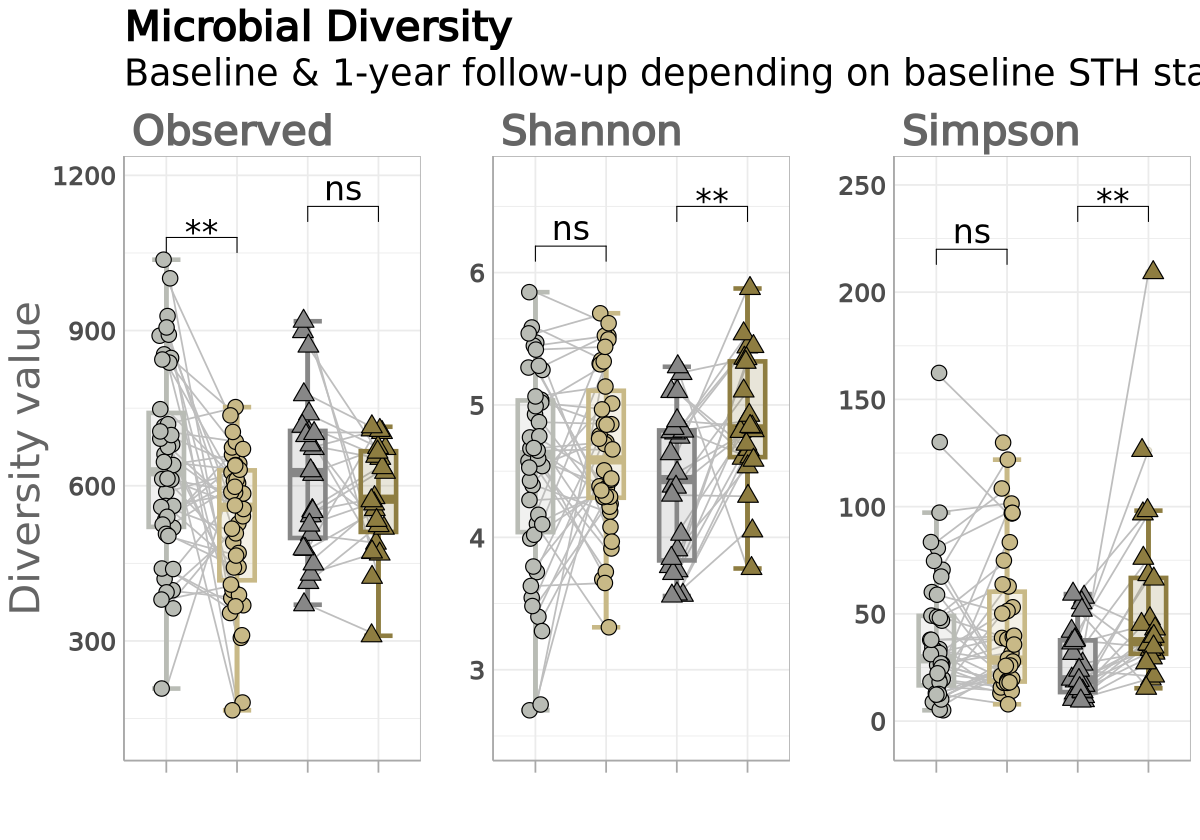

In [32]:
width = 10
height = 7
options(repr.plot.width=width, repr.plot.height=height)
comparisons_stats <- list(c('baseline_noSTH', 
                           'followup_noSTH'),
                         c('baseline_STH',
                           'followup_STH'))

p <- ggplot(alpha_div, aes(x=get(comparison_group), y=value)) + 
# lines connecting pairs of samples
      geom_line(aes(x = get(comparison_group), group = host_subject_id), color = "gray", size = 0.5) +
# plot error bar first
      stat_boxplot(aes(color = get(comparison_group)), geom = "errorbar", width = 0.4, lwd=1.3) +
# lay boxplot on top
      geom_boxplot(aes(color = get(comparison_group), 
                       fill=get(comparison_group)), alpha=0.2, lwd=1.3, width=0.5) + 
# overlay alpha-diversity values as dots
      geom_jitter(aes(color = get(comparison_group), fill=get(comparison_group), shape=get(comparison_group)), 
                  size=4, width=0.1, color='black')  + 
# add p-value statistics
      stat_pvalue_manual(data=test_res, label='p.signif', label.size=7) +
# build a separate plot for each alpha-diversity metric
      facet_wrap(~metric, scales = "free_y") + 
# change default colors and shapes
      scale_fill_manual(values = c('#b9bcb5', '#c8b987',
                                   '#878787', '#8e7d41')) + 
      scale_colour_manual(values = c('#b9bcb5', '#c8b987', 
                                     '#878787', '#8e7d41')) + 
      scale_shape_manual(values = c(21, 21, 24,  
                                    24, 21, 24)) +
# add titles
      labs(x = "", y = "Diversity value", title = "Microbial Diversity", 
           subtitle = "Baseline & 1-year follow-up depending on baseline STH status") +
# expand y limits to fit the p-value statistics into a plot
      scale_y_continuous(expand = expansion(mult = 0.1)) +
# custom plot design
      theme_minimal() +
      theme(axis.text=element_text(size=15),
            axis.title=element_text(size=25, face="bold"), 
            plot.title=element_text(size=25, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 25, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_text(size=0, angle=90, face='plain', color = "#FFFFFF00", hjust=1),
            axis.text.x = element_blank(),
            axis.title.y = element_text(color='#656565', face='plain'),
            axis.ticks.x=element_line(color = "darkgrey", linewidth = 0.5),
            axis.ticks.length.x.bottom=unit(0.5, "lines"),
            text = element_text(size = 25, face="bold"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(2, "lines"),
            legend.position="none") 

# ensure the order of the groups at the barplot
p$data[[comparison_group]] <- as.character(p$data[[comparison_group]])
p$data[[comparison_group]] <- factor(p$data[[comparison_group]], 
                                     levels = c('baseline_noSTH',  'followup_noSTH', 
                                                'baseline_STH', 'followup_STH'))

# save a plot with a scale of k
k = 0.3
ggsave(file=file.path('../../results/figures', 'figure2', 'baseline_followup.STHStatus.alpha_diversity.svg'), 
       plot=p, width=width*k, height=height*k, scaling = k)
# show a plot
print(p)